## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_horizVert_wavelet_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/wavelet/horizVert/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

Running 12760 CDFs


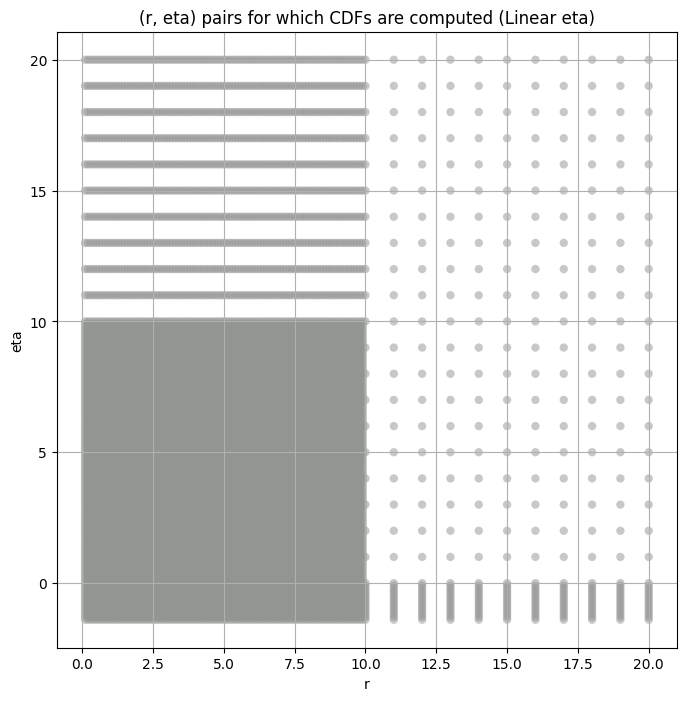

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2835.825400  2581.759000  3105.641600   2.125553    1.322311   
3       960.877800   913.511960  1010.549800   1.921159    1.503709   
4       272.219900   257.164830   287.636000   2.685072    2.167145   
5        62.487495    58.592915    66.509910   4.141825    3.365346   
6        11.940125    11.069906    12.845367   6.136143    4.953258   
7         2.066552     1.899631     2.242956   8.494821    6.802605   
8         0.295016     0.268812     0.324274  11.302633    8.270649   

       kurt_upper  total_samples  
layer                             
2        3.054123         3180.0  
3        2.410838        12720.0  
4        3.368225        50880.0  
5        5.149901       203520.0  
6        7.771889       814080.0  
7       11.325263      3256320.0  
8       20.854568     13025280.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

NameError: name 'GROUPS' is not defined

####
Layer  2


100%|██████████| 12760/12760 [00:02<00:00, 6344.77it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.016854802869844004 2835.8254


100%|██████████| 12760/12760 [00:01<00:00, 7291.17it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.018306990769708875 2319.505


100%|██████████| 12760/12760 [00:01<00:00, 7261.55it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.027525599098004006 2044.839


100%|██████████| 12760/12760 [00:01<00:00, 7267.94it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.036465347350508326 1841.9034


100%|██████████| 12760/12760 [00:01<00:00, 7081.13it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.04426517429996546 1682.7535


100%|██████████| 12760/12760 [00:01<00:00, 7289.23it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.058805797644185254 1430.9392


100%|██████████| 12760/12760 [00:01<00:00, 7348.79it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.073462458917528 1230.5132


100%|██████████| 12760/12760 [00:01<00:00, 7173.24it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.08654131748075444 1066.2384


100%|██████████| 12760/12760 [00:01<00:00, 7304.81it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.1008799235584209 930.04474


100%|██████████| 12760/12760 [00:01<00:00, 7358.16it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.11651761153012885 812.91406


100%|██████████| 12760/12760 [00:01<00:00, 7328.62it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.15833004844298448 550.4038
Number of samples: 3180, Without approximation : 3180.0


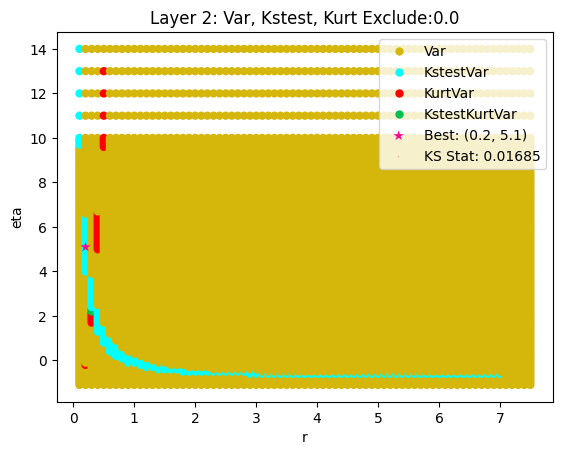

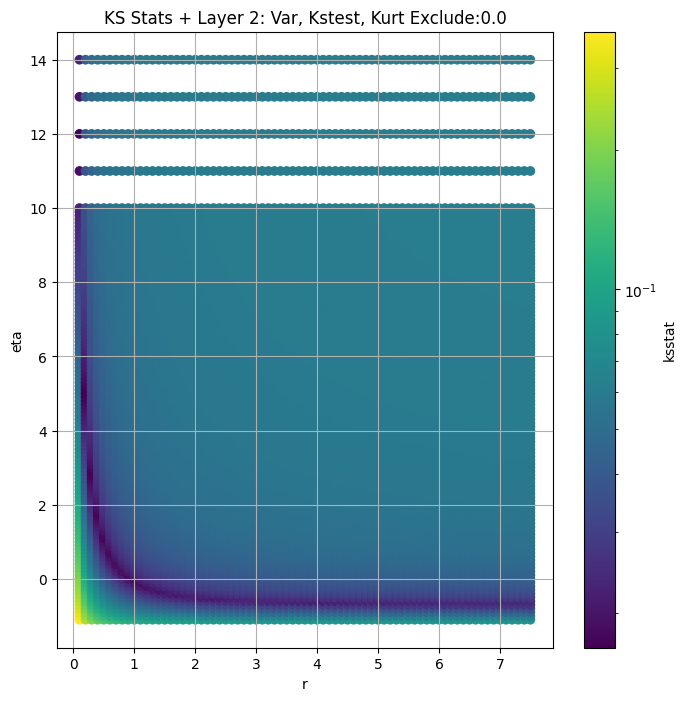

####
Layer  3


100%|██████████| 12760/12760 [00:06<00:00, 2119.43it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.0044464315325425385 960.8778


100%|██████████| 12760/12760 [00:05<00:00, 2136.83it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.006459481232834574 897.85376


100%|██████████| 12760/12760 [00:06<00:00, 2070.11it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.00845823911371868 858.3015


100%|██████████| 12760/12760 [00:06<00:00, 2111.33it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.010484021579075131 824.9335


100%|██████████| 12760/12760 [00:05<00:00, 2157.69it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.012364419620258693 795.44556


100%|██████████| 12760/12760 [00:06<00:00, 2109.55it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.015906605179369482 744.499


100%|██████████| 12760/12760 [00:07<00:00, 1708.18it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.020397755638157822 700.6961


100%|██████████| 12760/12760 [00:06<00:00, 2107.13it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.024779382552106877 662.5279


100%|██████████| 12760/12760 [00:06<00:00, 1904.01it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.02903263529580491 628.38245


100%|██████████| 12760/12760 [00:06<00:00, 2115.80it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.033244107787343435 597.47314


100%|██████████| 12760/12760 [00:05<00:00, 2215.06it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.04473698140203497 520.99963
Number of samples: 12720, Without approximation : 12720.0


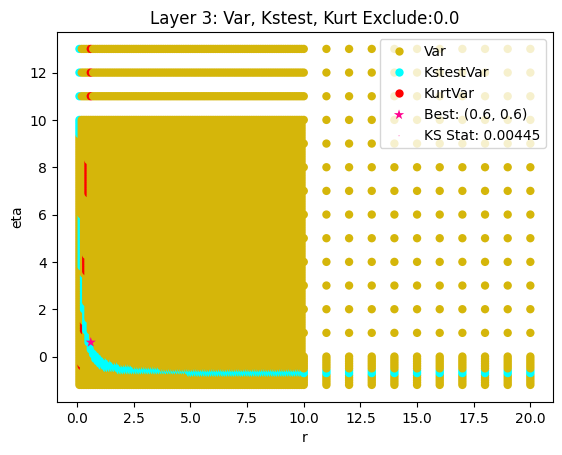

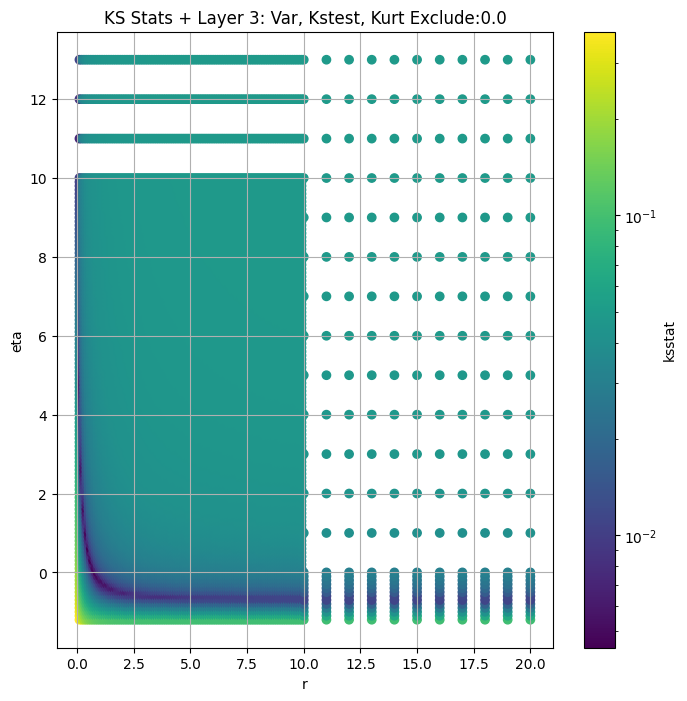

####
Layer  4


100%|██████████| 12760/12760 [00:27<00:00, 466.91it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.005413860376033364 272.2199


100%|██████████| 12760/12760 [00:29<00:00, 435.85it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.004907454703113712 265.19287


100%|██████████| 12760/12760 [00:23<00:00, 550.69it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.005644992366518775 260.27063


100%|██████████| 12760/12760 [00:22<00:00, 567.13it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.005154234231792509 255.9032


100%|██████████| 12760/12760 [00:23<00:00, 551.28it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.005553722697368868 251.94728


100%|██████████| 12760/12760 [00:22<00:00, 570.51it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.0066961202942630305 244.96402


100%|██████████| 12760/12760 [00:22<00:00, 557.57it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.0077319862613637325 238.80559


100%|██████████| 12760/12760 [00:36<00:00, 346.29it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.008870765157157234 233.22862


100%|██████████| 12760/12760 [00:24<00:00, 528.67it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.009997479129249753 228.14557


100%|██████████| 12760/12760 [00:23<00:00, 540.54it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.011083967036920273 223.41005


100%|██████████| 12760/12760 [00:23<00:00, 540.69it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.014398342293081012 210.7002
Number of samples: 50880, Without approximation : 50880.0


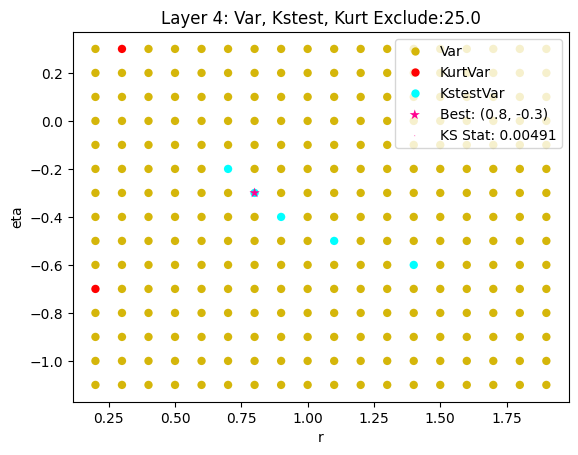

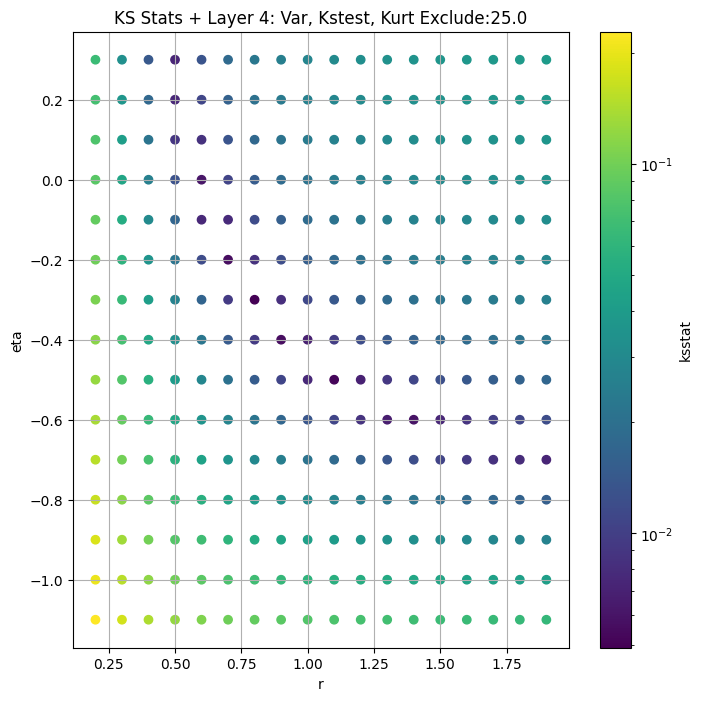

####
Layer  5


100%|██████████| 12760/12760 [00:44<00:00, 289.93it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.002375195116022799 62.487495


100%|██████████| 12760/12760 [00:45<00:00, 282.69it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.002783048161950741 61.267105


100%|██████████| 12760/12760 [00:44<00:00, 289.48it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.003412804394486879 60.387123


100%|██████████| 12760/12760 [00:44<00:00, 285.72it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.0035031687189882588 59.620384


100%|██████████| 12760/12760 [00:44<00:00, 289.90it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.003909279936601173 58.933285


100%|██████████| 12760/12760 [00:47<00:00, 268.19it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.004692558929500601 57.712353


100%|██████████| 12760/12760 [00:53<00:00, 239.40it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.005153662792678371 56.636536


100%|██████████| 12760/12760 [00:45<00:00, 282.92it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.005767426879583093 55.65363


100%|██████████| 12760/12760 [00:44<00:00, 285.36it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.006375110556021468 54.74234


100%|██████████| 12760/12760 [00:44<00:00, 287.76it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.006984814901316194 53.88874


100%|██████████| 12760/12760 [00:46<00:00, 274.51it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008466988793682129 51.594227
Number of samples: 100000, Without approximation : 203520.0


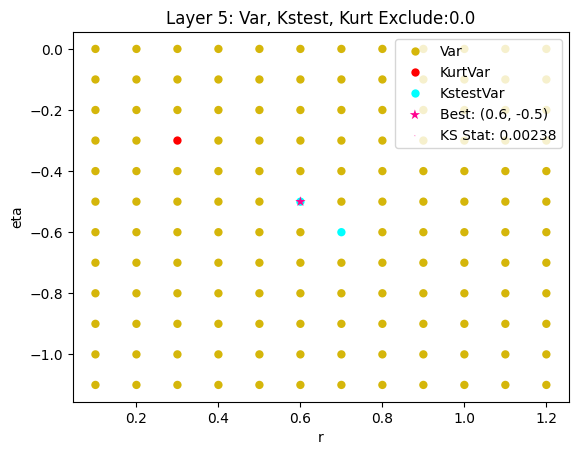

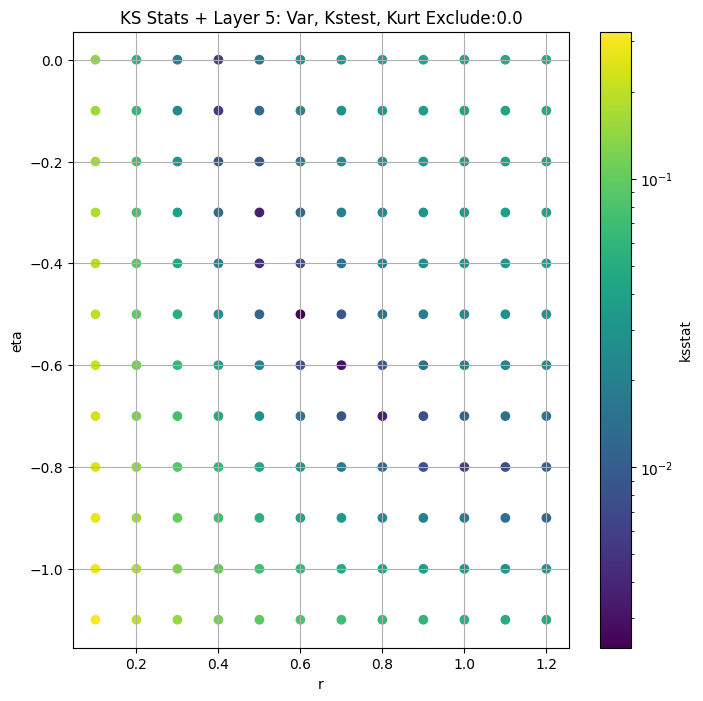

####
Layer  6


100%|██████████| 12760/12760 [00:45<00:00, 279.66it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.003817391980272755 11.940125


100%|██████████| 12760/12760 [00:47<00:00, 269.65it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.005248530780427196 11.649893


100%|██████████| 12760/12760 [00:46<00:00, 274.67it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.006159841565901547 11.447717


100%|██████████| 12760/12760 [00:48<00:00, 262.46it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.005319684561225224 11.272619


100%|██████████| 12760/12760 [00:47<00:00, 267.81it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.004988018800634486 11.113964


100%|██████████| 12760/12760 [00:47<00:00, 271.05it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.005176783709265775 10.831807


100%|██████████| 12760/12760 [00:46<00:00, 276.24it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.006020492511164266 10.581346


100%|██████████| 12760/12760 [00:47<00:00, 266.28it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.006574508849279903 10.354142


100%|██████████| 12760/12760 [00:53<00:00, 238.93it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.006764852968586754 10.145789


100%|██████████| 12760/12760 [00:49<00:00, 256.72it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.006996172507839904 9.952064


100%|██████████| 12760/12760 [00:47<00:00, 268.57it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.008790075154822885 9.439072
Number of samples: 100000, Without approximation : 814080.0


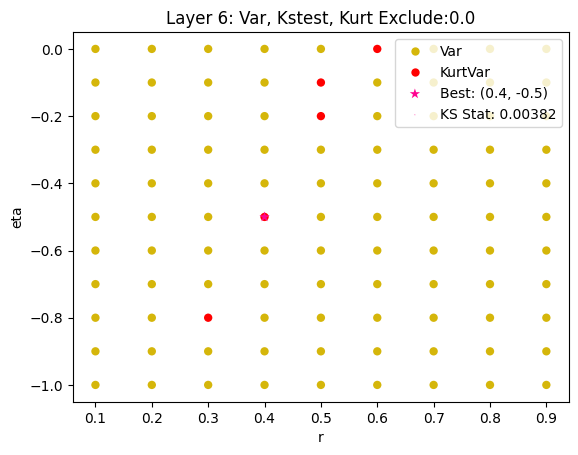

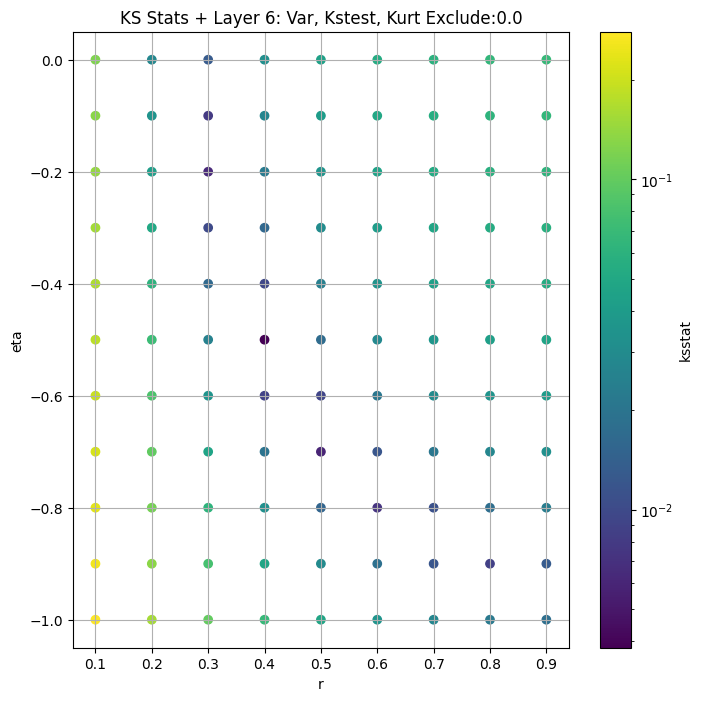

####
Layer  7


100%|██████████| 12760/12760 [00:45<00:00, 278.25it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.006297889270153456 2.0665524


100%|██████████| 12760/12760 [00:43<00:00, 293.05it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.0067364175999047315 2.0056481


100%|██████████| 12760/12760 [00:44<00:00, 286.37it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.0064844636741280826 1.9635992


100%|██████████| 12760/12760 [00:47<00:00, 267.32it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.006688025301716194 1.927567


100%|██████████| 12760/12760 [00:46<00:00, 275.96it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.0074846092790613605 1.8952063


100%|██████████| 12760/12760 [00:46<00:00, 274.80it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.007861185576117369 1.8380708


100%|██████████| 12760/12760 [00:45<00:00, 278.76it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.00753721661982365 1.788063


100%|██████████| 12760/12760 [00:44<00:00, 289.84it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.00855406030382544 1.7429748


100%|██████████| 12760/12760 [00:46<00:00, 272.07it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.009617693380518988 1.7016772


100%|██████████| 12760/12760 [00:44<00:00, 289.69it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.008904849557178462 1.6634108


100%|██████████| 12760/12760 [00:47<00:00, 270.63it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.010295017371121984 1.5626131
Number of samples: 100000, Without approximation : 3256320.0


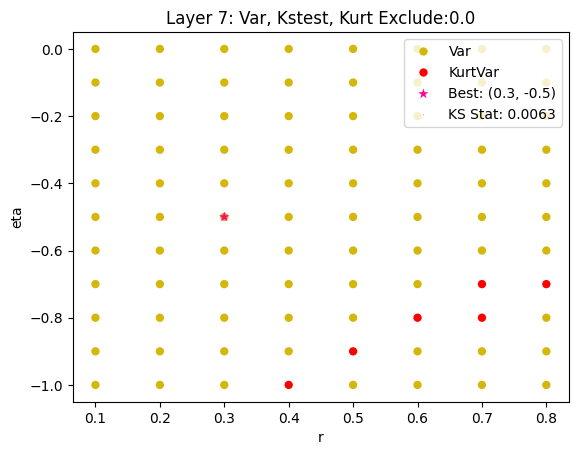

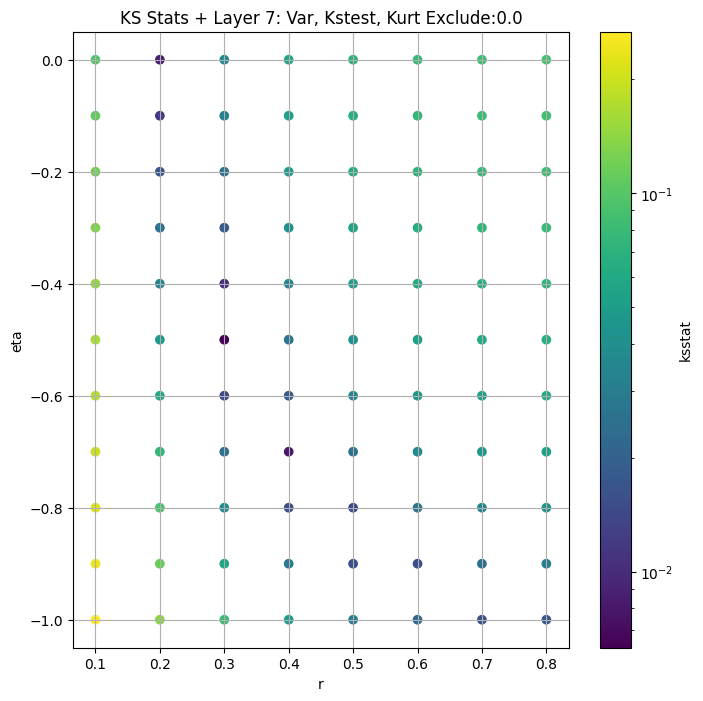

####
Layer  8


100%|██████████| 12760/12760 [00:46<00:00, 275.48it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.007419446759775378 0.29501566


100%|██████████| 12760/12760 [00:47<00:00, 271.25it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.008065342499333161 0.28415617


100%|██████████| 12760/12760 [00:43<00:00, 295.99it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.0066566949052839774 0.27732477


100%|██████████| 12760/12760 [00:43<00:00, 291.16it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.007471324323229056 0.2715485


100%|██████████| 12760/12760 [00:42<00:00, 296.78it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.008266787035109135 0.26641732


100%|██████████| 12760/12760 [00:42<00:00, 297.43it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.00867178813285796 0.25742984


100%|██████████| 12760/12760 [00:43<00:00, 294.32it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.009478269901385172 0.24960077


100%|██████████| 12760/12760 [00:43<00:00, 295.99it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.008723273403703047 0.24258594


100%|██████████| 12760/12760 [00:42<00:00, 299.99it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.009746352433443906 0.23620194


100%|██████████| 12760/12760 [00:42<00:00, 297.43it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.010388277088604292 0.23032491


100%|██████████| 12760/12760 [00:42<00:00, 300.45it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.011479680391477953 0.21496433
Number of samples: 100000, Without approximation : 13025280.0


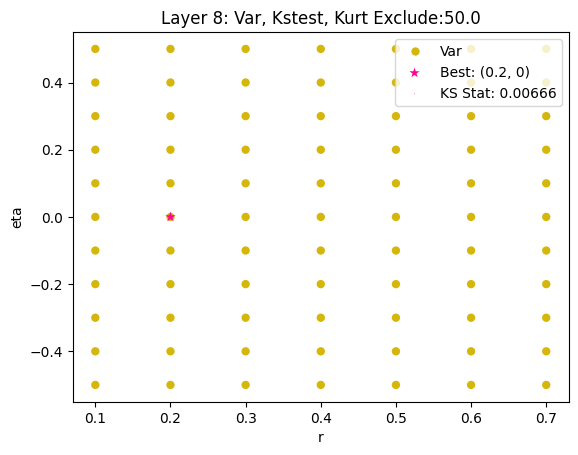

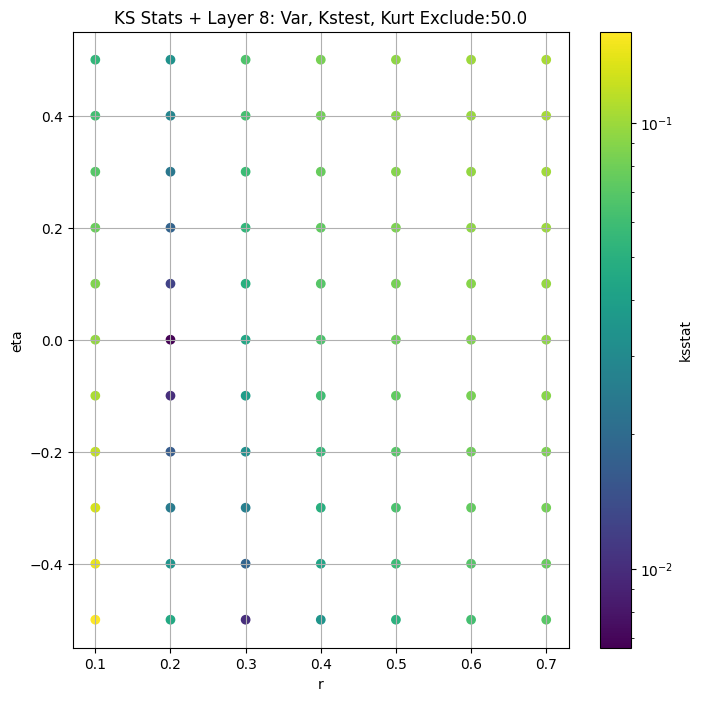

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2835.825400  2581.759000  3105.641600   2.125553    1.322311   
3       960.877800   913.511960  1010.549800   1.921159    1.503709   
4       272.219900   257.164830   287.636000   2.685072    2.167145   
5        62.487495    58.592915    66.509910   4.141825    3.365346   
6        11.940125    11.069906    12.845367   6.136143    4.953258   
7         2.066552     1.899631     2.242956   8.494821    6.802605   
8         0.295016     0.268812     0.324274  11.302633    8.270649   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.054123         3180.0             0.016855        0.2          5.1   
3        2.410838        12720.0             0.004446        0.6          0.6   
4        3.368225        50880.0             0.004907        0.8         -0.3   
5        5.149901       203520.0             0.002375        0.6         -0.5   
6        7.771889       814080.0             0.003817        0.4         -0.5   
7       11.325263      3256320.0             0.006298        0.3         -0.5   
8       20.854568     13025280.0             0.006657        0.2          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.000054                     0.0         2835.825400   
3         103.204293                     0.0          960.877800   
4         146.124715                    25.0          265.192870   
5          20.304922                     0.0           62.487495   
6           0.661354                     0.0           11.940125   
7           0.014758                     0.0            2.066552   
8           0.000004                    50.0            0.277325   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.024030  
3                     0.012029  
4                     0.006018  
5                     0.003010  
6                     0.001505  
7                     0.000753  
8                     0.000376

In [ ]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [ ]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 621/621 [00:00<00:00, 2224.14it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.0468407357737044, var: 1682.7535400390625


100%|██████████| 621/621 [00:00<00:00, 7032.84it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.038324739527665685, var: 1841.9034423828125


100%|██████████| 621/621 [00:00<00:00, 6647.97it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.02933847994487948, var: 2044.8389892578125


100%|██████████| 621/621 [00:00<00:00, 7316.32it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.020624306346458954, var: 2319.5048828125


100%|██████████| 621/621 [00:00<00:00, 7104.22it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01666356866576335, var: 2835.825439453125
Number of samples: 3180, Without approximation : 3180.0


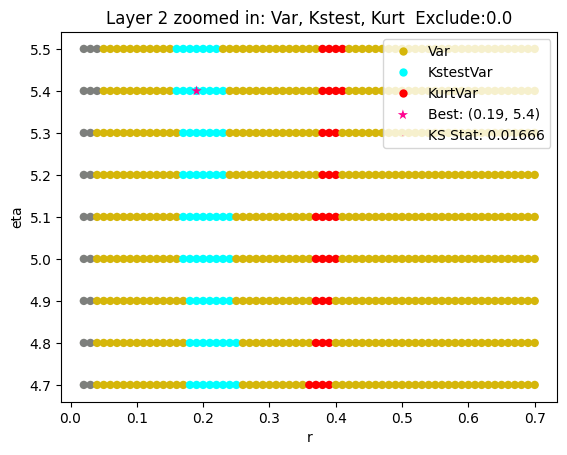

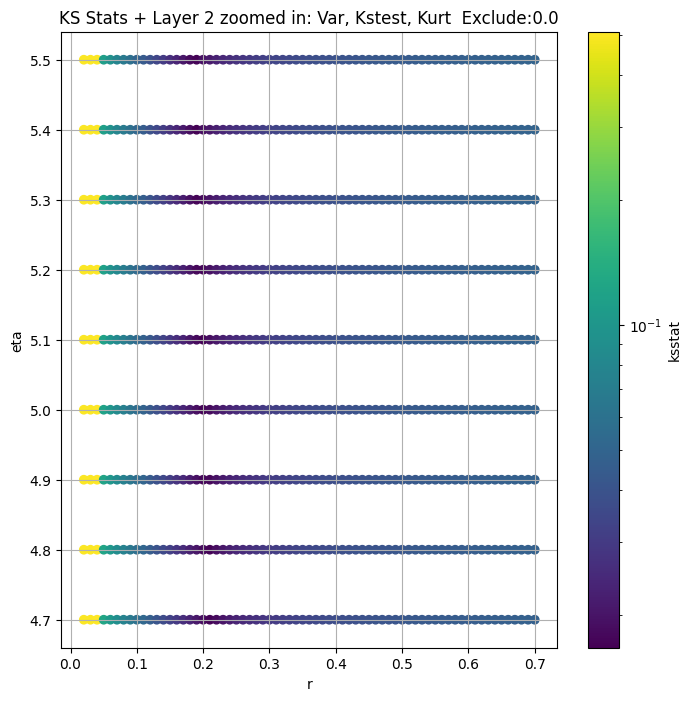

Layer 3


100%|██████████| 891/891 [00:00<00:00, 1291.45it/s]


Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.01383347348665509, var: 795.445556640625


100%|██████████| 891/891 [00:00<00:00, 2181.85it/s]


Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.011532376899204944, var: 824.9334716796875


100%|██████████| 891/891 [00:00<00:00, 2207.89it/s]


Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.009436728443716458, var: 858.301513671875


100%|██████████| 891/891 [00:00<00:00, 2230.91it/s]


Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.007160353303869105, var: 897.853759765625


100%|██████████| 891/891 [00:00<00:00, 2224.27it/s]


Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.004179753733429825, var: 960.8778076171875
Number of samples: 12720, Without approximation : 12720.0


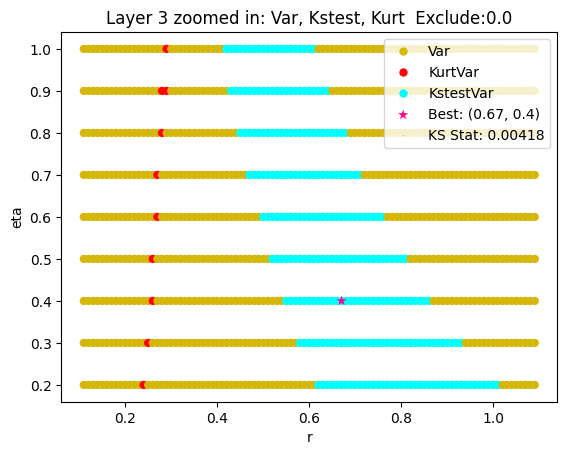

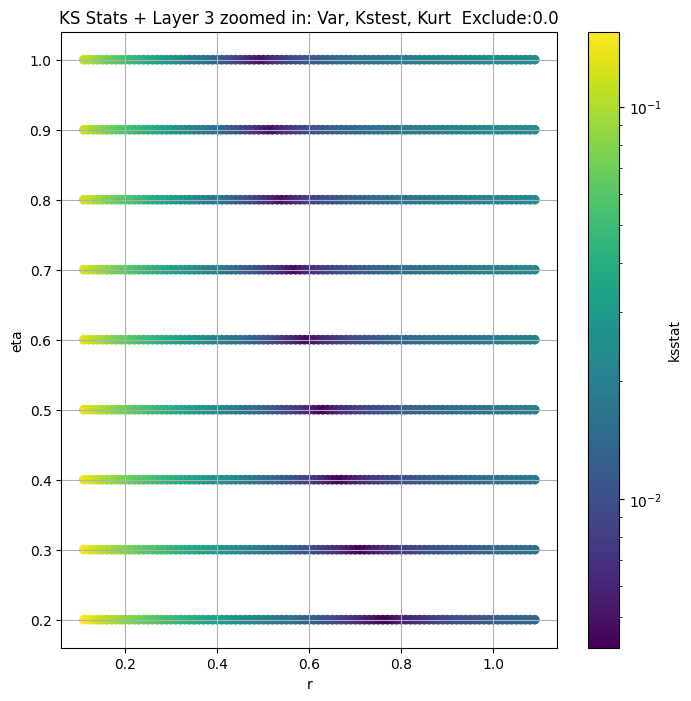

Layer 4


100%|██████████| 1539/1539 [00:03<00:00, 479.83it/s]


Finding Minimum after computing 1539 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.006759089663906037, var: 248.3169403076172


100%|██████████| 1539/1539 [00:02<00:00, 591.52it/s]


Finding Minimum after computing 1539 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.005872784525996488, var: 251.94728088378906


100%|██████████| 1539/1539 [00:02<00:00, 591.29it/s]


Finding Minimum after computing 1539 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.00511449456120483, var: 255.9031982421875


100%|██████████| 1539/1539 [00:02<00:00, 576.25it/s]


Finding Minimum after computing 1539 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.0049642810656687075, var: 260.2706298828125


100%|██████████| 1539/1539 [00:02<00:00, 584.81it/s]


Finding Minimum after computing 1539 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.004871819770226882, var: 265.19287109375


100%|██████████| 1539/1539 [00:02<00:00, 533.98it/s]


Finding Minimum after computing 1539 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.00483248234817657, var: 272.21990966796875
Number of samples: 50880, Without approximation : 50880.0


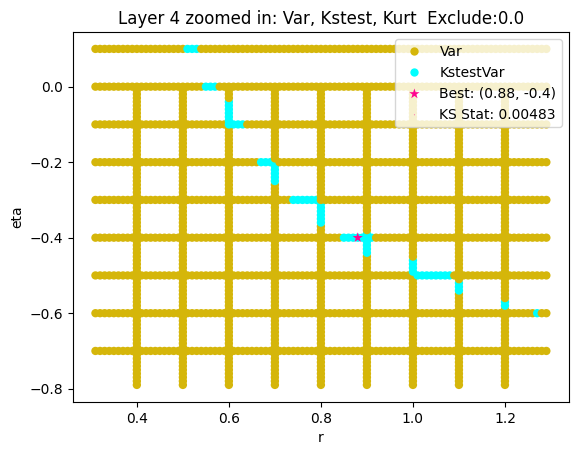

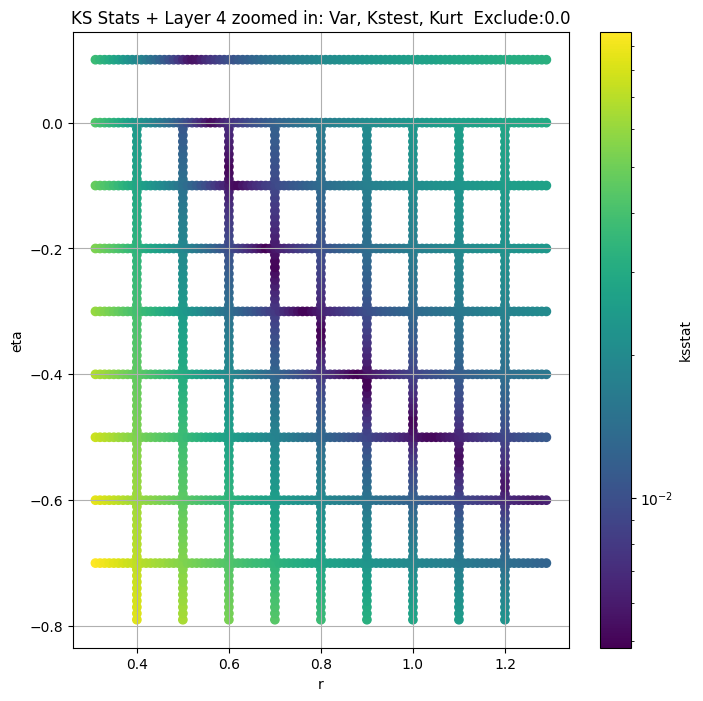

Layer 5


100%|██████████| 1701/1701 [00:05<00:00, 286.95it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.0038212033186159067, var: 58.933284759521484


100%|██████████| 1701/1701 [00:05<00:00, 299.50it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.0034681980270824253, var: 59.620384216308594


100%|██████████| 1701/1701 [00:05<00:00, 301.15it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.003099541016948759, var: 60.387123107910156


100%|██████████| 1701/1701 [00:05<00:00, 300.88it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.0027683640210343086, var: 61.26710510253906


100%|██████████| 1701/1701 [00:05<00:00, 297.17it/s]


Finding Minimum after computing 1701 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0021674701436820154, var: 62.48749542236328
Number of samples: 100000, Without approximation : 203520.0


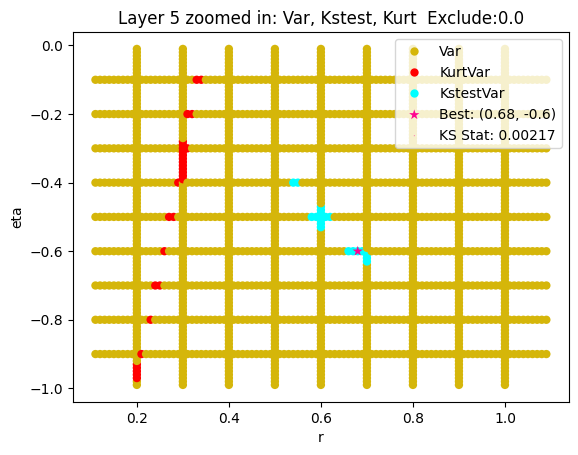

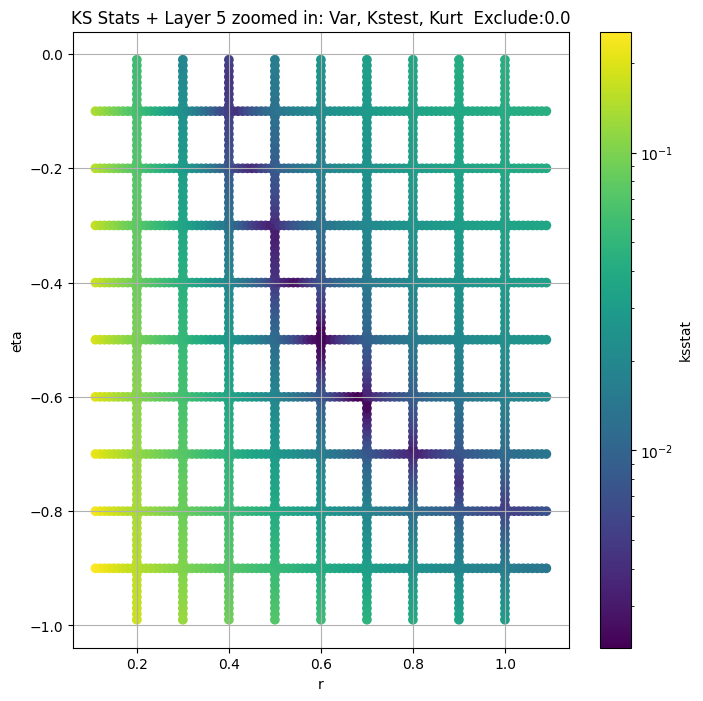

Layer 6


100%|██████████| 1512/1512 [00:05<00:00, 294.20it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.0042345811388667665, var: 11.113964080810547


100%|██████████| 1512/1512 [00:05<00:00, 296.93it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.003978031703029239, var: 11.272619247436523


100%|██████████| 1512/1512 [00:05<00:00, 299.17it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.003866132343935069, var: 11.44771671295166


100%|██████████| 1512/1512 [00:05<00:00, 296.59it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.0035058567038618316, var: 11.649892807006836


100%|██████████| 1512/1512 [00:05<00:00, 278.75it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.0032317922656623366, var: 11.940125465393066
Number of samples: 100000, Without approximation : 814080.0


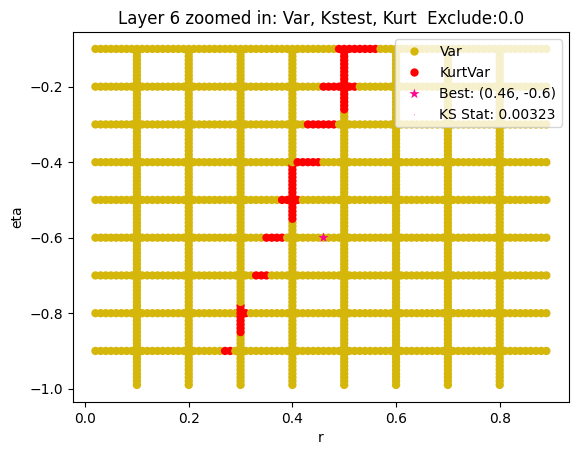

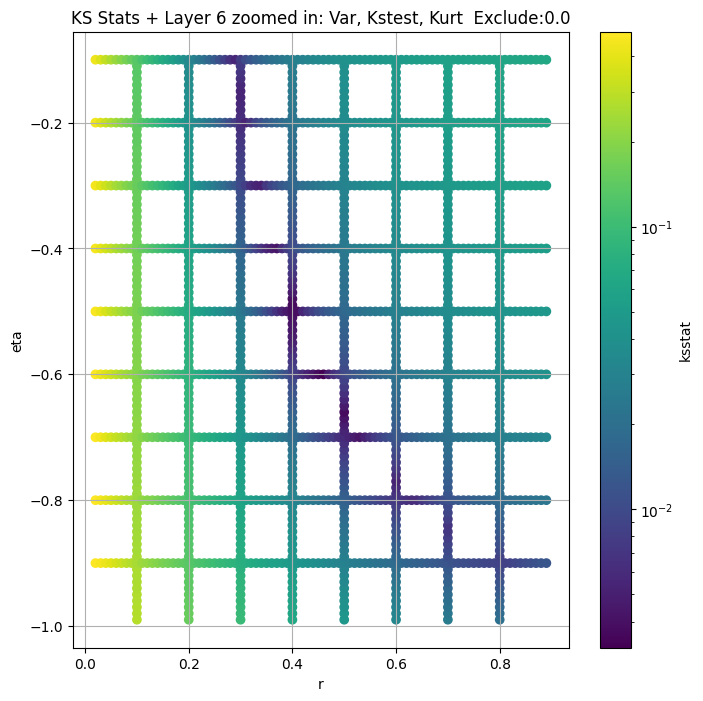

Layer 7


100%|██████████| 1332/1332 [00:04<00:00, 296.15it/s]


Finding Minimum after computing 1332 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.005783935811280866, var: 1.895206332206726


100%|██████████| 1332/1332 [00:04<00:00, 284.02it/s]


Finding Minimum after computing 1332 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.005839773260945869, var: 1.9275670051574707


100%|██████████| 1332/1332 [00:04<00:00, 303.56it/s]


Finding Minimum after computing 1332 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.005222427425480208, var: 1.9635992050170898


100%|██████████| 1332/1332 [00:04<00:00, 297.43it/s]


Finding Minimum after computing 1332 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.005375803632071852, var: 2.005648136138916


100%|██████████| 1332/1332 [00:04<00:00, 288.82it/s]


Finding Minimum after computing 1332 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.004664902550804928, var: 2.0665524005889893
Number of samples: 100000, Without approximation : 3256320.0


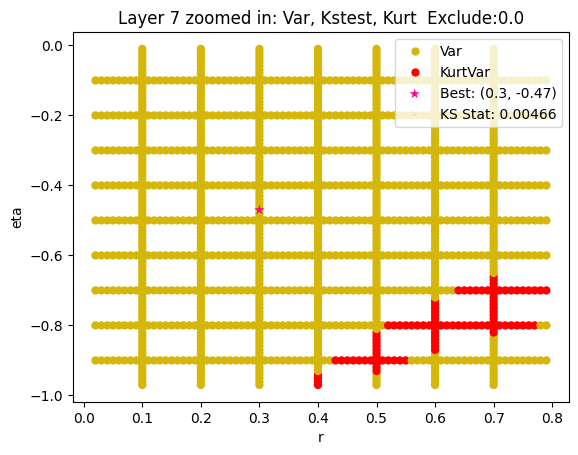

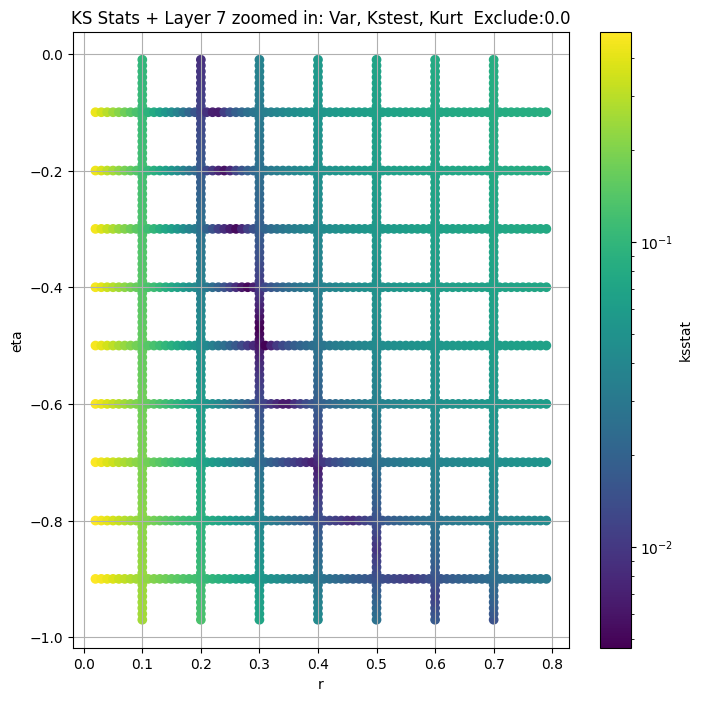

Layer 8


100%|██████████| 936/936 [00:03<00:00, 295.89it/s]


Finding Minimum after computing 936 CDFs
layer 8, 50.0 + 100 = 150, ksstat: 0.00737218387904176, var: 0.257429838180542


100%|██████████| 936/936 [00:03<00:00, 291.05it/s]


Finding Minimum after computing 936 CDFs
layer 8, 50.0 + 75 = 125, ksstat: 0.007443029719033323, var: 0.26174506545066833


100%|██████████| 936/936 [00:03<00:00, 305.51it/s]


Finding Minimum after computing 936 CDFs
layer 8, 50.0 + 50 = 100, ksstat: 0.007093074166087898, var: 0.26641732454299927


100%|██████████| 936/936 [00:03<00:00, 293.41it/s]


Finding Minimum after computing 936 CDFs
layer 8, 50.0 + 25 = 75, ksstat: 0.006770218368636782, var: 0.2715485095977783


100%|██████████| 936/936 [00:03<00:00, 303.62it/s]


Finding Minimum after computing 936 CDFs
layer 8, 50.0 + 0 = 50, ksstat: 0.0066566949052839774, var: 0.27732476592063904


100%|██████████| 936/936 [00:03<00:00, 304.55it/s]


Finding Minimum after computing 936 CDFs
layer 8, 50.0 + -25 = 25, ksstat: 0.006162419948081255, var: 0.2841561734676361


100%|██████████| 936/936 [00:03<00:00, 293.23it/s]


Finding Minimum after computing 936 CDFs
layer 8, 50.0 + -50 = 0, ksstat: 0.005697776331507365, var: 0.2950156629085541
Number of samples: 100000, Without approximation : 13025280.0


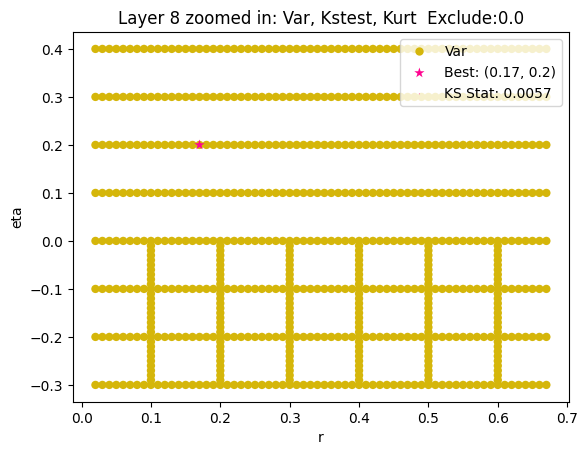

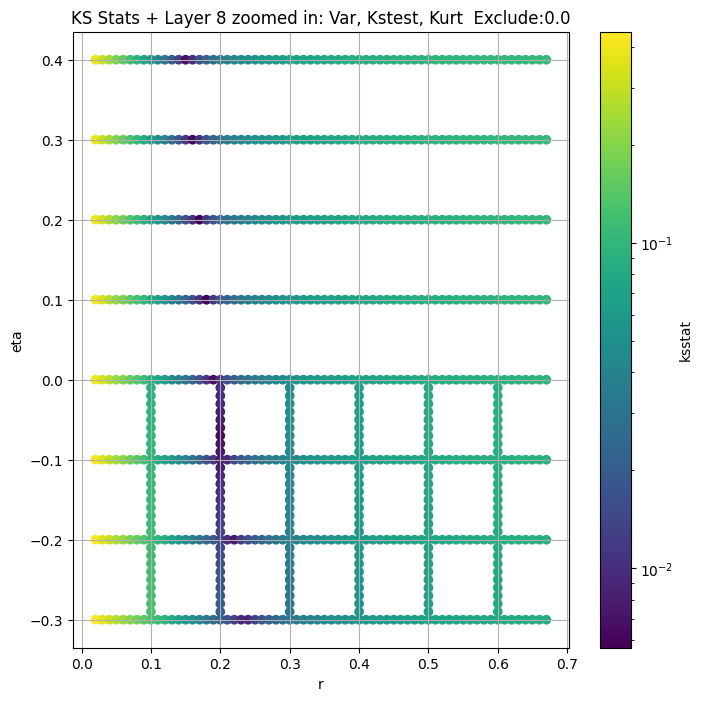

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2835.825400  2581.759000  3105.641600   2.125553    1.322311   
3       960.877800   913.511960  1010.549800   1.921159    1.503709   
4       272.219900   257.164830   287.636000   2.685072    2.167145   
5        62.487495    58.592915    66.509910   4.141825    3.365346   
6        11.940125    11.069906    12.845367   6.136143    4.953258   
7         2.066552     1.899631     2.242956   8.494821    6.802605   
8         0.295016     0.268812     0.324274  11.302633    8.270649   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.054123         3180.0             0.016855        0.2          5.1   
3        2.410838        12720.0             0.004446        0.6          0.6   
4        3.368225        50880.0             0.004907        0.8         -0.3   
5        5.149901       203520.0             0.002375        0.6         -0.5   
6        7.771889       814080.0             0.003817        0.4         -0.5   
7       11.325263      3256320.0             0.006298        0.3         -0.5   
8       20.854568     13025280.0             0.006657        0.2          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.000054                     0.0         2835.825439   
3         103.204293                     0.0          960.877808   
4         146.124715                    25.0          272.219910   
5          20.304922                     0.0           62.487495   
6           0.661354                     0.0           11.940125   
7           0.014758                     0.0            2.066552   
8           0.000004                    50.0            0.295016   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.024030          0.016664    0.19      5.40   
3                     0.012029          0.004180    0.67      0.40   
4                     0.006018          0.004832    0.88     -0.40   
5                     0.003010          0.002167    0.68     -0.60   
6                     0.001505          0.003232    0.46     -0.60   
7                     0.000753          0.004665    0.30     -0.47   
8                     0.000376          0.005698    0.17      0.20   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      1.297176e-05                  0.0         6787  
3      1.805247e+02                  0.0       108666  
4      2.004038e+02                  0.0        76320  
5      3.349366e+01                  0.0       386370  
6      1.655580e+00                  0.0       171720  
7      1.367142e-02                  0.0        85860  
8      1.129697e-07                  0.0        57240

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

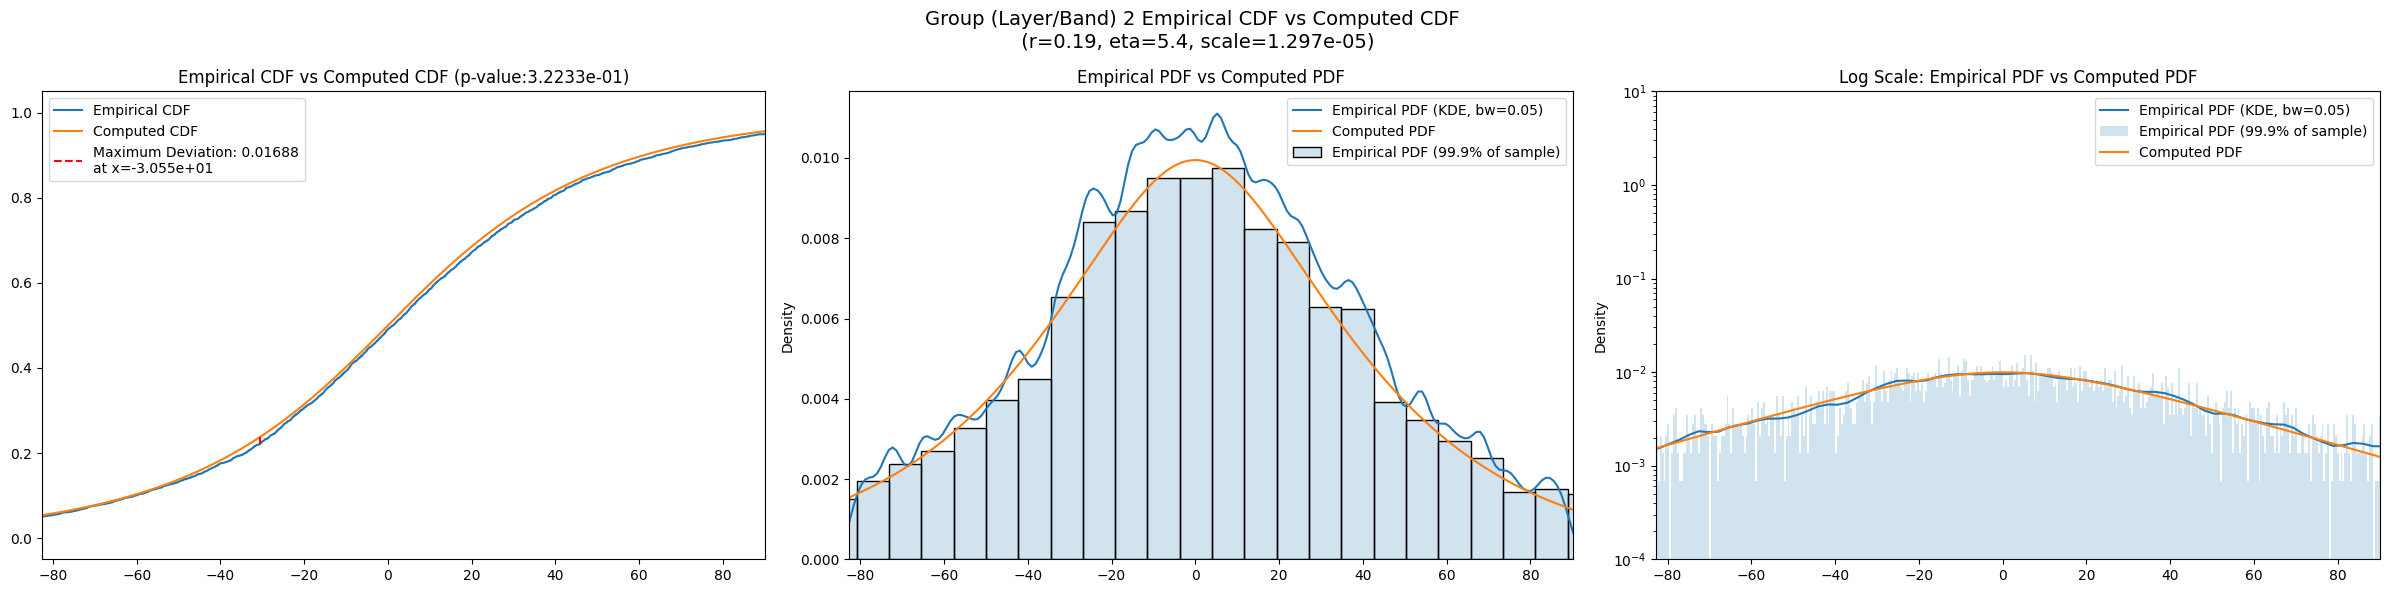

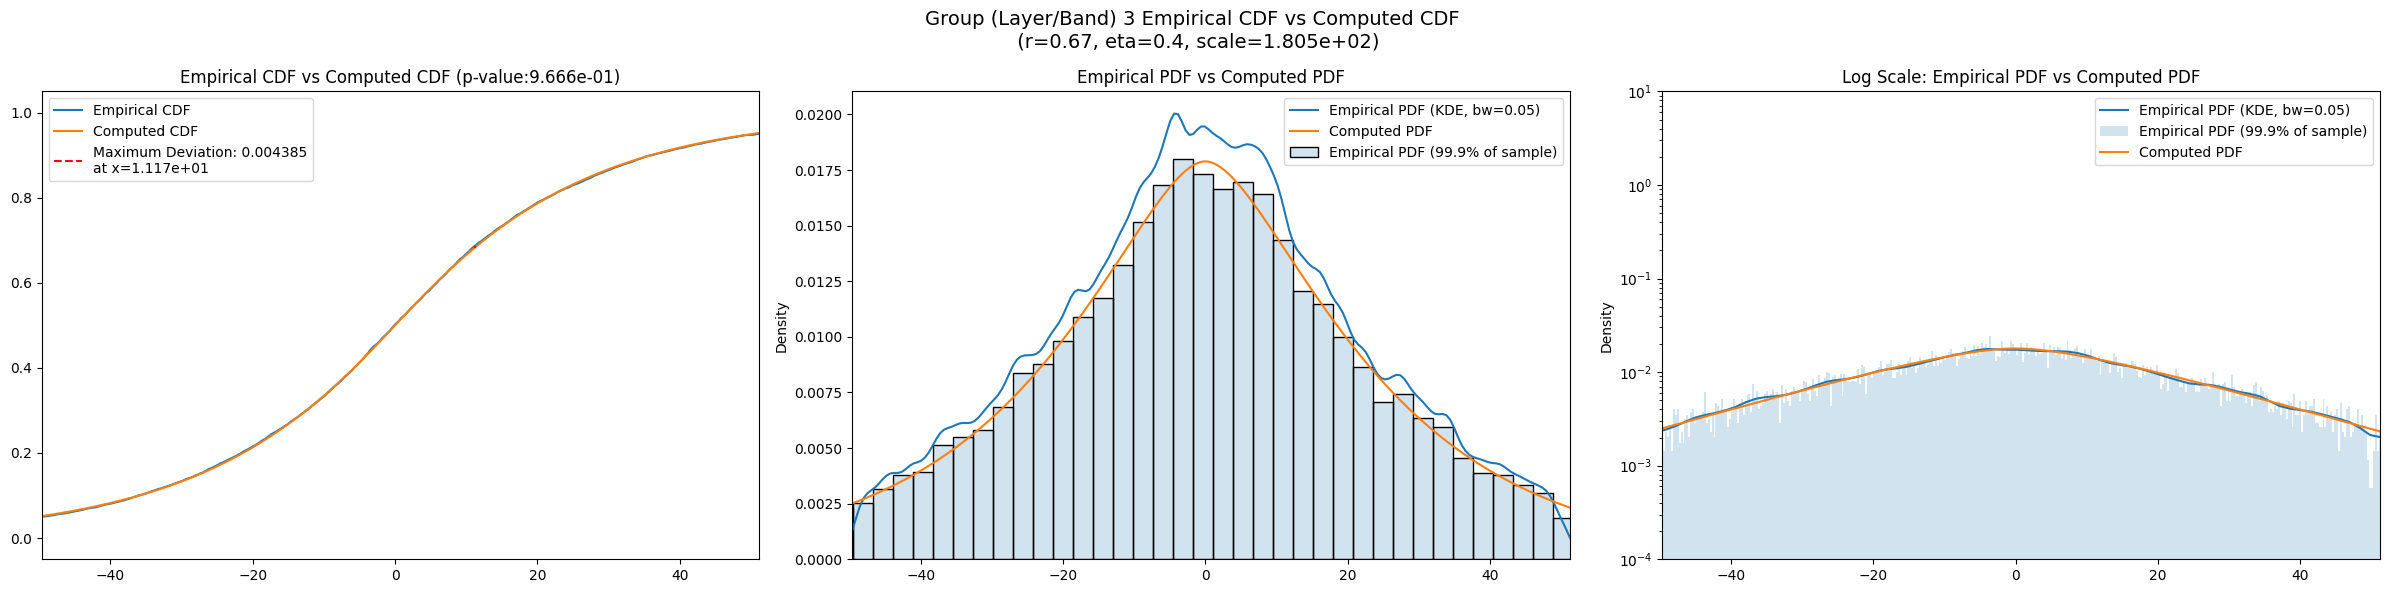

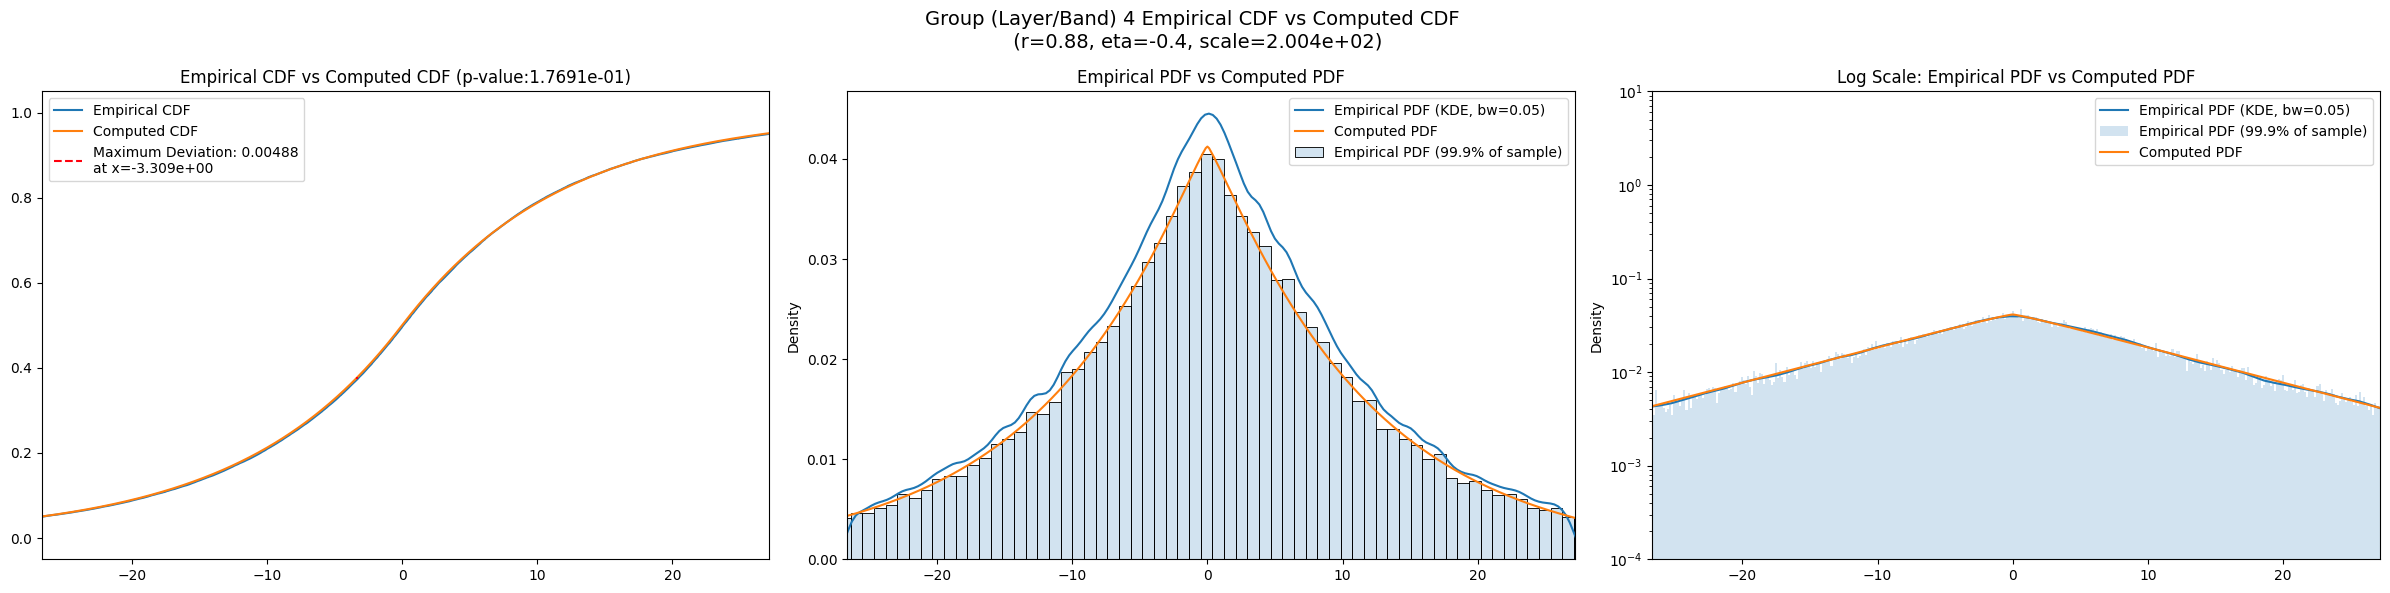

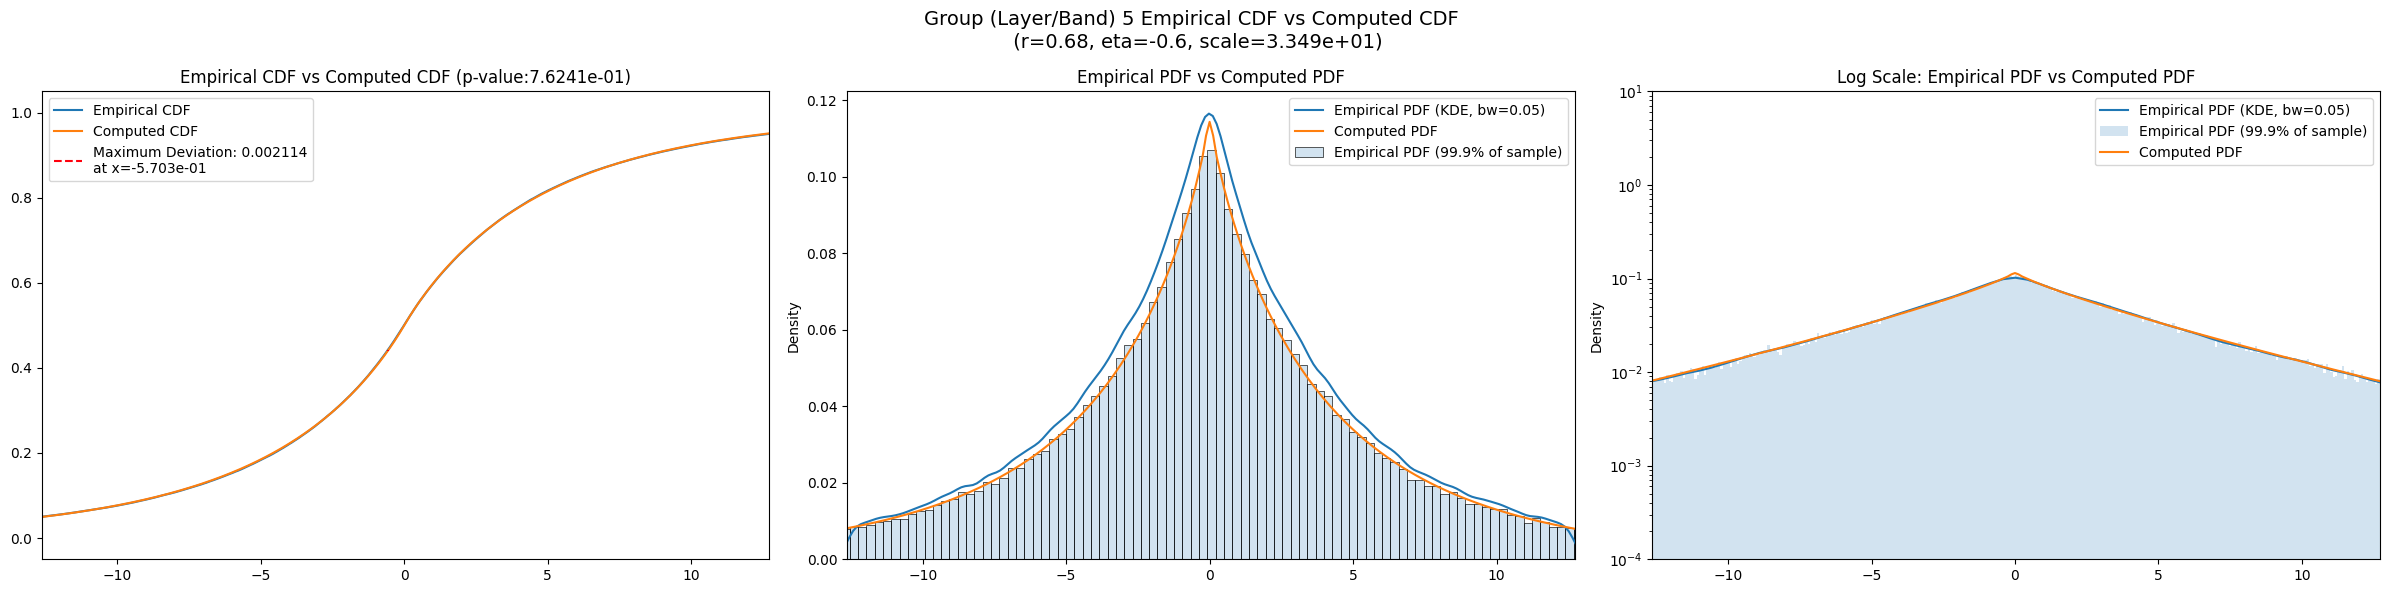

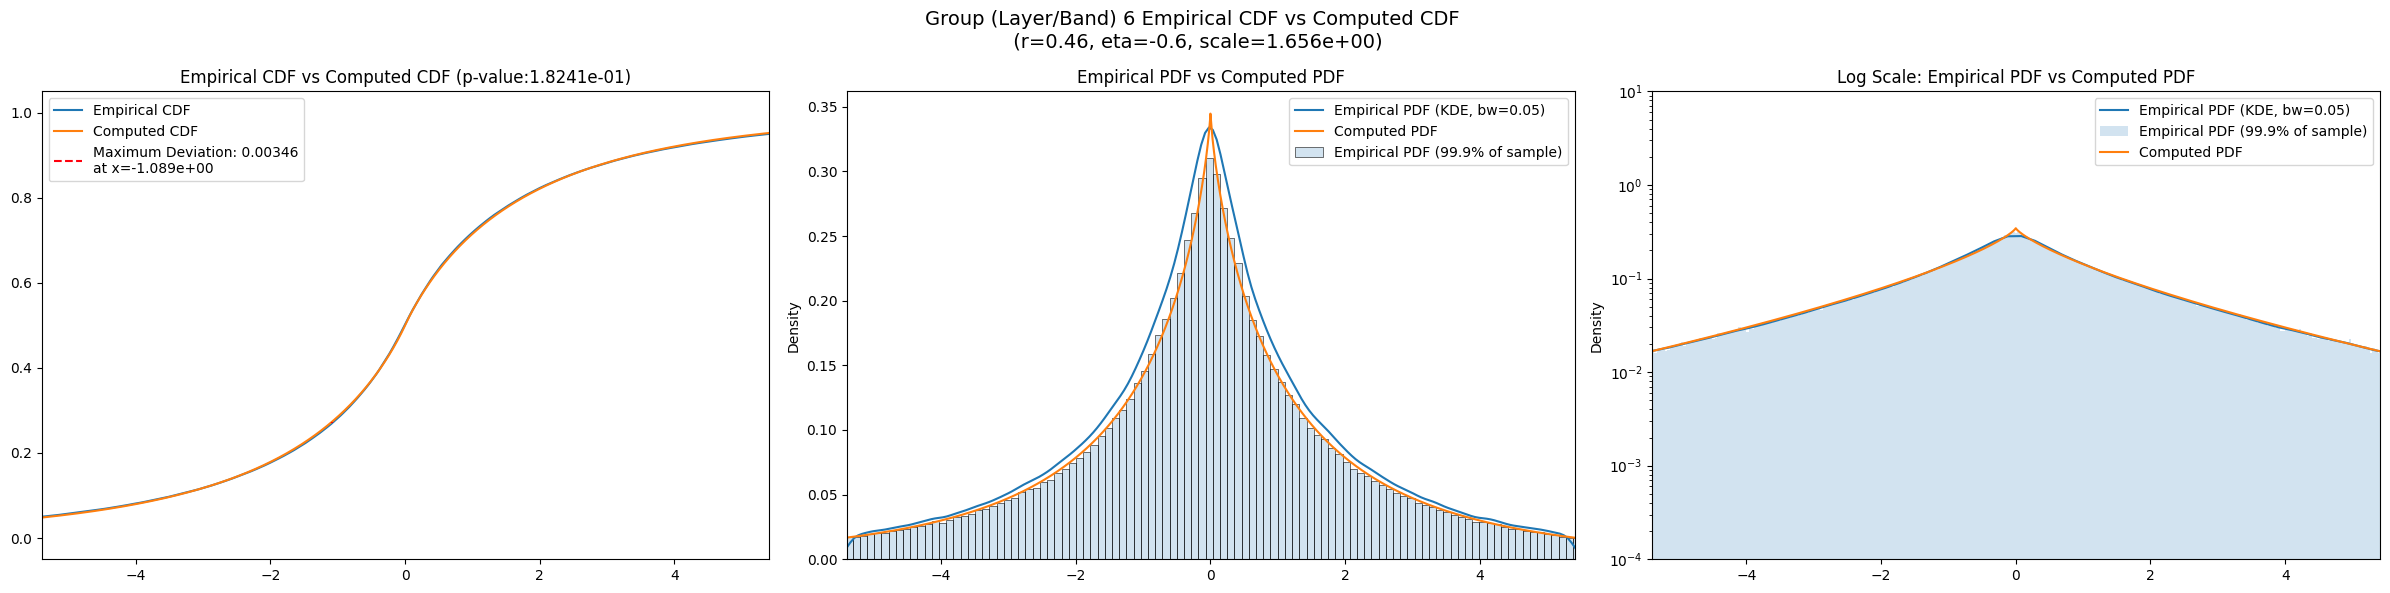

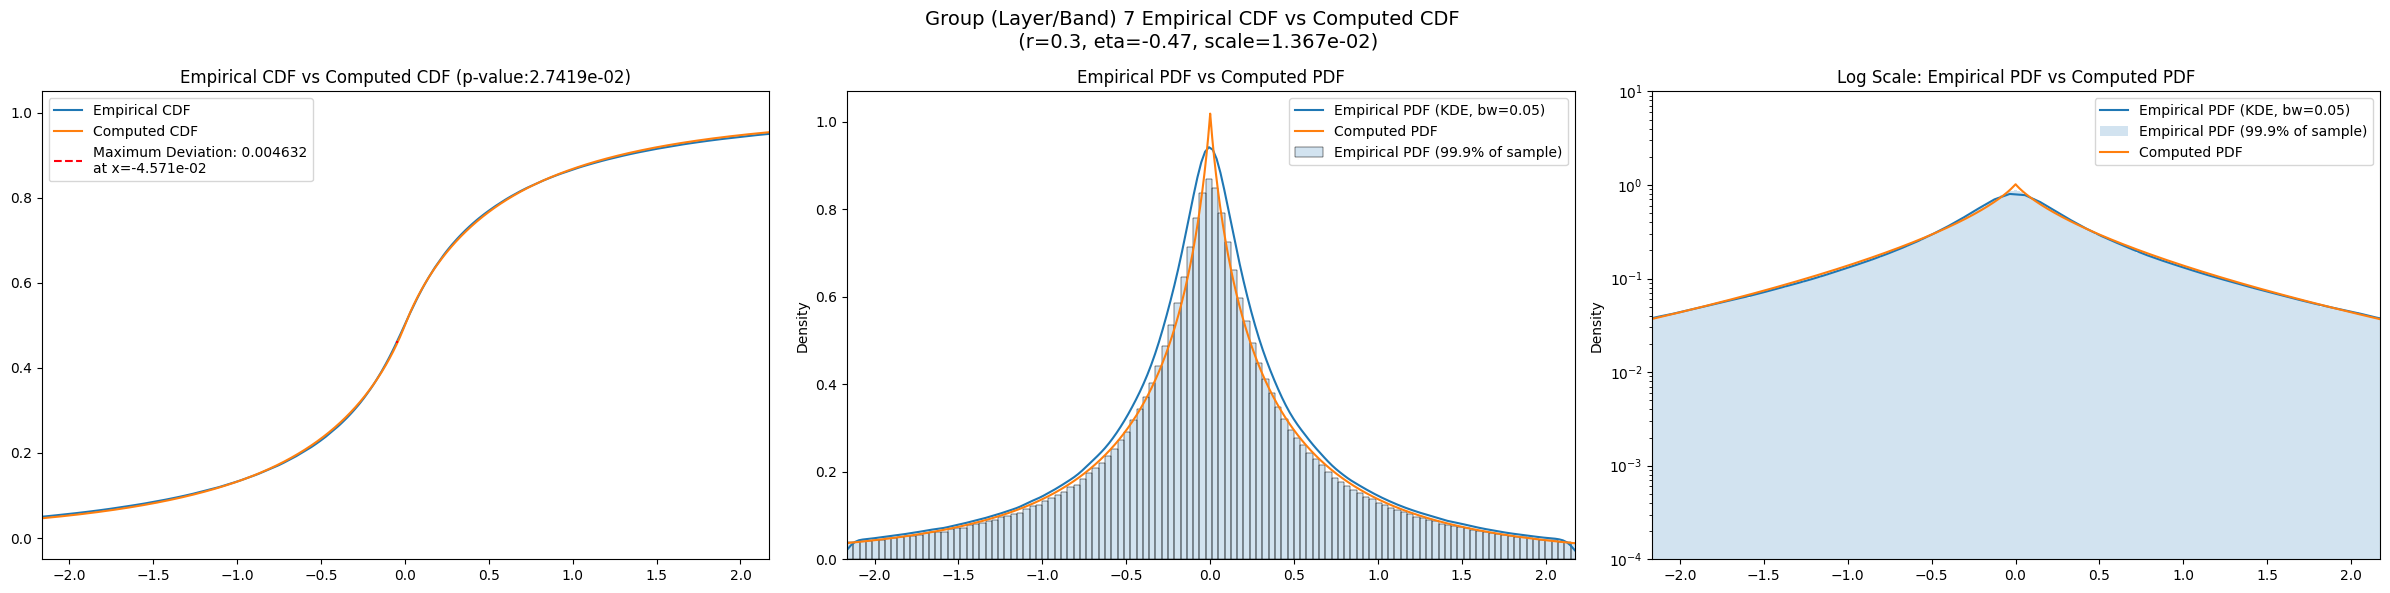

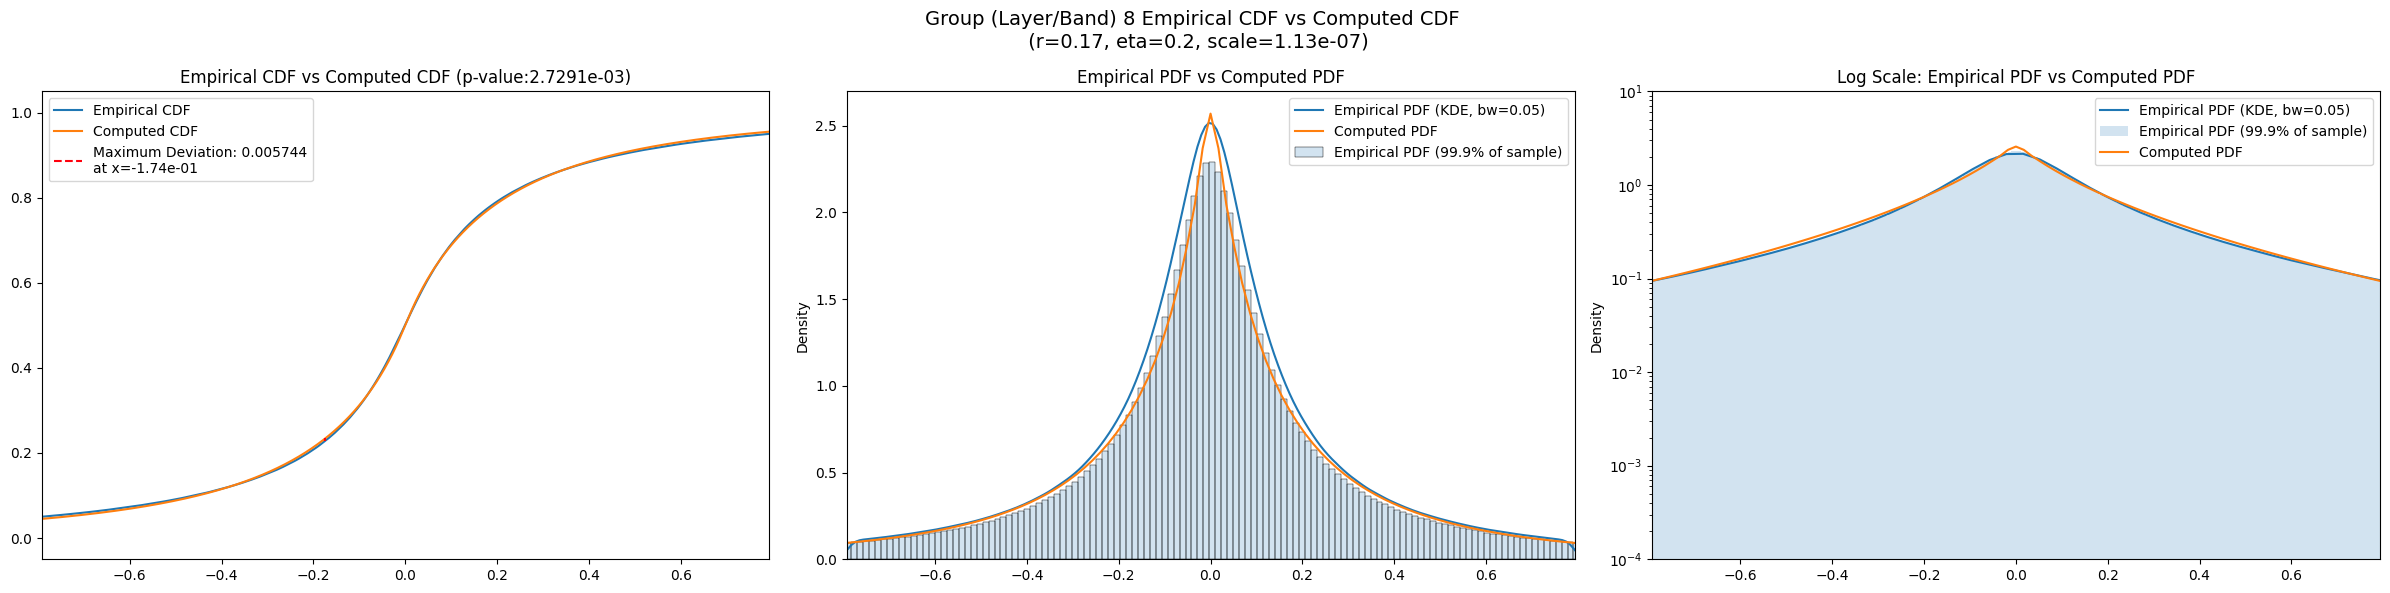

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2835.825400  2581.759000  3105.641600   2.125553    1.322311   
3       960.877800   913.511960  1010.549800   1.921159    1.503709   
4       272.219900   257.164830   287.636000   2.685072    2.167145   
5        62.487495    58.592915    66.509910   4.141825    3.365346   
6        11.940125    11.069906    12.845367   6.136143    4.953258   
7         2.066552     1.899631     2.242956   8.494821    6.802605   
8         0.295016     0.268812     0.324274  11.302633    8.270649   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.054123         3180.0             0.016855        0.2          5.1   
3        2.410838        12720.0             0.004446        0.6          0.6   
4        3.368225        50880.0             0.004907        0.8         -0.3   
5        5.149901       203520.0             0.002375        0.6         -0.5   
6        7.771889       814080.0             0.003817        0.4         -0.5   
7       11.325263      3256320.0             0.006298        0.3         -0.5   
8       20.854568     13025280.0             0.006657        0.2          0.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       45.319200              0.029562          7.556300e-03   
3      ...       26.651300              0.023927          9.297480e-07   
4      ...       13.285100              0.030938          9.585640e-43   
5      ...        5.809090              0.037516         2.611310e-249   
6      ...        2.222990              0.047186          0.000000e+00   
7      ...        0.813824              0.054346          0.000000e+00   
8      ...        0.289022              0.055181          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          42.133400             0.023351         6.139350e-02  34.424800   
3          23.504100             0.011128         8.505080e-02  19.080400   
4          11.769800             0.005285         1.161680e-01   9.507290   
5           5.089340             0.009714         4.143830e-17   4.124600   
6           1.943070             0.019687        1.651380e-274   1.552970   
7           0.715003             0.027010         0.000000e+00   0.568224   
8           0.255115             0.028353         0.000000e+00   0.202337   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.021024   1.185670e-01          3.366198e-01  
3           0.015201   5.542940e-03          9.787072e-01  
4           0.011060   7.793970e-06          1.850258e-01  
5           0.013334   7.347030e-32          2.941228e-01  
6           0.021891   0.000000e+00          8.218206e-08  
7           0.027110   0.000000e+00          5.622055e-62  
8           0.026175   0.000000e+00          0.000000e+00  

[7 rows x 30 columns]

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.016855                 0.024030          0.016664   
3                 0.004446                 0.012029          0.004180   
4                 0.004907                 0.006018          0.004832   
5                 0.002375                 0.003010          0.002167   
6                 0.003817                 0.001505          0.003232   
7                 0.006298                 0.000753          0.004665   
8                 0.006657                 0.000376          0.005698   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.029562             0.023351       0.021024  
3                  0.023927             0.011128       0.015201  
4                  0.030938             0.005285       0.011060  
5                  0.037516             0.009714       0.013334  
6                  0.047186             0.019687       0.021891  
7                  0.054346             0.027010       0.027110  
8                  0.055181             0.028353       0.026175

In [ ]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             2835.825439          0.016664    0.19      5.40  1.297176e-05   
3              960.877808          0.004180    0.67      0.40  1.805247e+02   
4              272.219910          0.004832    0.88     -0.40  2.004038e+02   
5               62.487495          0.002167    0.68     -0.60  3.349366e+01   
6               11.940125          0.003232    0.46     -0.60  1.655580e+00   
7                2.066552          0.004665    0.30     -0.47  1.367142e-02   
8                0.295016          0.005698    0.17      0.20  1.129697e-07   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0

In [ ]:
eng.quit()